In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/a-large-scale-fish-dataset/Segmentation_example_script.m
/kaggle/input/a-large-scale-fish-dataset/README.txt
/kaggle/input/a-large-scale-fish-dataset/license.txt
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00033.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00004.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00023.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00041.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00024.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00035.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00045.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00038.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00025.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/0000

Datayı indirdik ve kullanım için hazır şimdi veri ön işlemlerine geçeceğiz ilk olarak elimizdeki resim sayısını inceleyeceğiz
her balık türü için kaç tane RGB ve etiketlenmiş (ground truth) görüntü bulunduğunu hesaplayacağız ve bu bilgileri tablo formatında (Pandas DataFrame) organize edeceğiz.

In [2]:
import os
import pandas as pd

dataset_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'

data = []

for fish_type in os.listdir(dataset_dir):
    fish_path = os.path.join(dataset_dir, fish_type)
    
    if os.path.isdir(fish_path):
        rgb_images_path = os.path.join(fish_path, fish_type)
        rgb_images = len(os.listdir(rgb_images_path))
        
        gt_images_path = os.path.join(fish_path, f'{fish_type} GT')
        gt_images = len(os.listdir(gt_images_path))
        
        total_images = rgb_images + gt_images
        data.append([fish_type, rgb_images, gt_images, total_images])

df = pd.DataFrame(data, columns=['Fish Type', 'RGB Images', 'Ground Truth Images', 'Total Images'])
print(df)


            Fish Type  RGB Images  Ground Truth Images  Total Images
0     Hourse Mackerel        1000                 1000          2000
1     Black Sea Sprat        1000                 1000          2000
2            Sea Bass        1000                 1000          2000
3          Red Mullet        1000                 1000          2000
4               Trout        1000                 1000          2000
5  Striped Red Mullet        1000                 1000          2000
6              Shrimp        1000                 1000          2000
7     Gilt-Head Bream        1000                 1000          2000
8       Red Sea Bream        1000                 1000          2000


şimdi veriyi okuyabilmek için bir dataframe oluşturacağız ve aynı zamanda etiketleme işlemini de gerçekleştireceğiz
ancak burada sadece RGB resimleri yani orijinal balık resimlerini kullanacağız çünkü amacımız sınıflandırma yapacak bir model eğitimi

In [3]:
import os
from PIL import Image
import numpy as np

dataset_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'

images = []
labels = []

fish_types = os.listdir(dataset_dir)
fish_to_label = {fish_type: idx for idx, fish_type in enumerate(fish_types)}

for fish_type in fish_types:
    fish_path = os.path.join(dataset_dir, fish_type)
    
    if os.path.isdir(fish_path):
        # RGB 
        rgb_images_path = os.path.join(fish_path, fish_type)
        if os.path.isdir(rgb_images_path):
            for filename in os.listdir(rgb_images_path):
                if filename.endswith(('.png', '.jpg', '.jpeg')):  
                    img_path = os.path.join(rgb_images_path, filename)
                    image = Image.open(img_path).convert('RGB')  
                    image = image.resize((128, 128))
                    image = np.array(image)
                    images.append(image)
                    labels.append(fish_to_label[fish_type]) 

images = np.array(images)
labels = np.array(labels)

print(f"Total : {len(images)}") 

Total : 9000


şimdi ise piksel değerlerini 0-255 aralığından 0-1 aralığına indiriyoruz.makine öğrenimi modellerinin daha kararlı, hızlı ve doğru bir şekilde öğrenmesini sağlamak için yaygın bir adımdır.

In [4]:
images = images / 255.0

Verimizi test ve train olmak üzere ikiye böleceğiz train ksımı ile eğitim gerçekleştirip eğitim sonunda oluşturduğumuz modeli test verisi ile sınayacağız

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print(f"Train: {len(X_train)}")
print(f"Test: {len(X_test)}")


Train: 7200
Test: 1800


şimdi ise train seti için veri artırma yapacağız yani resimleri döndürme,kaydırma gibi işlemler ile veri çeşitliliğini artırıyoruz bu modelin farklı tipteki resimleri de öğrenebilmesini ve farklı resimler için daha iyi sonuç vermesini sağlar

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,  
    width_shift_range=0.2,  
    height_shift_range=0.2,  
    horizontal_flip=True  
)

datagen.fit(X_train)

Modelimizi Oluşturacağız
Convolutional Layer - görüntü özellikleri öğrenilir

Max Pooling Katmanı - çıktının boyutunu azaltarak modelin hesaplama yükünü azaltır

2.Convolutional Layer - daha derin özelliklerin öğrenilmesini sağlar

2. Max Pooling katmanı - 1.deki gibi boyut azaltarak permormansı artırır
3. 
...

Flatten Katmanı- Convolutional ve pooling katmanlarından gelen çok boyutlu veriyi tek bir vektör haline getirir

Fully Connected Layer - Öğrenilen özelliklerin birleşimini yapar, sınıflandrıma için önemli bir katmandır

Dropout Katmanı - modelin aşırı öğrenmesini (overfitting) önler

en sonda tablo şeklinde modelimizin özetini göreceğiz


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))  # 3 renk kanalı: RGB
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Aşırı öğrenmeyi (overfitting) önlemek için dropout

model.add(Dense(len(fish_types), activation='softmax'))  # Balık türleri sayısı kadar çıkış (9 tür olduğu varsayılmıştır)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',  # Çok sınıflı sınıflandırma için uygun kayıp fonksiyonu
              metrics=['accuracy'])

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,306,188 (12.61 MB)

 Trainable params: 3,306,188 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Artık modeli oluşturduğumuz yapay sinir ağı ile eğitebliriz öncelikle eğitim sürecinde 5 epoch boyunca performans artmazsa erken durdurma yapacağız(aşırı öğrenme durumundan kaçınmak için)

her epoch için kayıp ve doğruluk değerlerini takp ederek model performansını gözleyeceğiz

In [8]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32), 
    validation_data=(X_test, y_test),
    epochs=30,  
    callbacks=[early_stop],  
    verbose=2
)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1729691492.868610      98 service.cc:145] XLA service 0x7862cc003290 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729691492.868683      98 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729691492.868703      98 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1729691498.210539      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


225/225 - 36s - 161ms/step - accuracy: 0.2767 - loss: 1.9283 - val_accuracy: 0.5494 - val_loss: 1.2758
Epoch 2/30
225/225 - 27s - 122ms/step - accuracy: 0.4899 - loss: 1.3168 - val_accuracy: 0.6628 - val_loss: 0.9051
Epoch 3/30
225/225 - 27s - 120ms/step - accuracy: 0.6010 - loss: 1.0413 - val_accuracy: 0.8022 - val_loss: 0.6000
Epoch 4/30
225/225 - 27s - 121ms/step - accuracy: 0.6858 - loss: 0.8341 - val_accuracy: 0.8117 - val_loss: 0.4914
Epoch 5/30
225/225 - 27s - 121ms/step - accuracy: 0.7442 - loss: 0.6924 - val_accuracy: 0.8600 - val_loss: 0.3855
Epoch 6/30
225/225 - 27s - 122ms/step - accuracy: 0.7790 - loss: 0.5990 - val_accuracy: 0.8422 - val_loss: 0.4192
Epoch 7/30
225/225 - 27s - 121ms/step - accuracy: 0.8032 - loss: 0.5321 - val_accuracy: 0.8694 - val_loss: 0.3504
Epoch 8/30
225/225 - 27s - 121ms/step - accuracy: 0.8328 - loss: 0.4547 - val_accuracy: 0.8822 - val_loss: 0.3476
Epoch 9/30
225/225 - 27s - 121ms/step - accuracy: 0.8524 - loss: 0.4019 - val_accuracy: 0.9006 - va

Eğitim sürecini görselleştirerek overfitting olup olmadığını görecek ve modelin zamanla gelişimini somutlaştıracağız

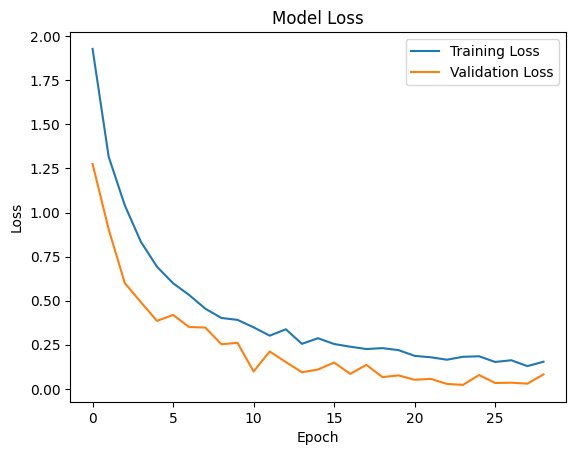

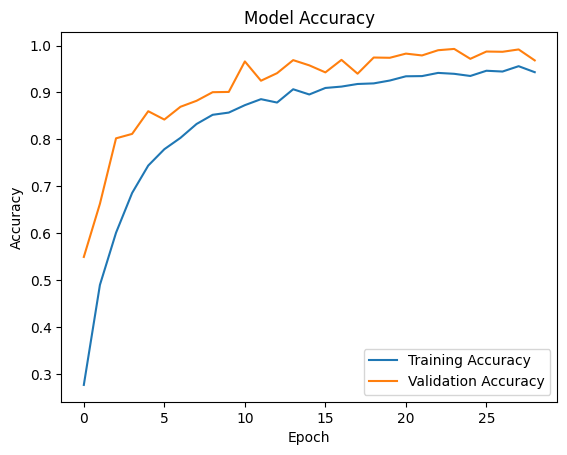

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Modelimizi test için ayırdığımız resimlerin tamamı için sınayacağız ve doğruluğunu yüzde olarak göstereceğiz

In [10]:
y_pred = model.predict(X_test)  
y_pred_classes = np.argmax(y_pred, axis=1)

accuracy = np.mean(y_pred_classes == y_test)
num_test_images = len(X_test)

correct_predictions = np.sum(y_pred_classes == y_test)
incorrect_predictions = num_test_images - correct_predictions

print(f"accuracy: {accuracy * 100:.2f}%")
print(f"Total test images: {num_test_images}")
print(f"Correct predictions: {correct_predictions}")
print(f"Incorrect predictions: {incorrect_predictions}")


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
accuracy: 99.28%
Total test images: 1800
Correct predictions: 1787
Incorrect predictions: 13


görüldüğü üzere yüksek bir doğruluk oranına sahibiz neredeyse %95 luk bir doğruluk elde ettik ve model eğitilirken 30 olarak belirlenen epoch sayısı erken durdurma ile durdu bazen de son eposchlarda doğruluk azaldı bu da epoch sayısını artırmanın model performansında pozitif bir etkinin olmayacağına bir işarettir bunun yerine hiperparemetre opitmizasyonu ile modelin performansını artırmayı deneyeceğiz.

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def create_optimized_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Flatten(),

        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

input_shape = (128, 128, 3)
num_classes = len(fish_types)
model = create_optimized_model(input_shape, num_classes)

initial_learning_rate = 0.001
optimizer = Adam(learning_rate=initial_learning_rate)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=30,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")


Epoch 1/30
225/225 - 67s - 298ms/step - accuracy: 0.4453 - loss: 1.8883 - val_accuracy: 0.1172 - val_loss: 14.5113 - learning_rate: 0.0010
Epoch 2/30
225/225 - 30s - 133ms/step - accuracy: 0.6783 - loss: 0.9200 - val_accuracy: 0.1889 - val_loss: 5.4805 - learning_rate: 0.0010
Epoch 3/30
225/225 - 30s - 135ms/step - accuracy: 0.7799 - loss: 0.6204 - val_accuracy: 0.9117 - val_loss: 0.2429 - learning_rate: 0.0010
Epoch 4/30
225/225 - 30s - 132ms/step - accuracy: 0.7875 - loss: 0.6261 - val_accuracy: 0.8533 - val_loss: 0.4139 - learning_rate: 0.0010
Epoch 5/30
225/225 - 30s - 133ms/step - accuracy: 0.8685 - loss: 0.3754 - val_accuracy: 0.4172 - val_loss: 2.9011 - learning_rate: 0.0010
Epoch 6/30
225/225 - 30s - 133ms/step - accuracy: 0.8949 - loss: 0.3014 - val_accuracy: 0.5939 - val_loss: 1.7868 - learning_rate: 0.0010
Epoch 7/30
225/225 - 30s - 133ms/step - accuracy: 0.9183 - loss: 0.2323 - val_accuracy: 0.9772 - val_loss: 0.0680 - learning_rate: 0.0010
Epoch 8/30
225/225 - 30s - 133ms/

bu 2.modeli test verileri ile sınayarak modelin performansını gözlemleyelim

In [14]:
y_pred = model.predict(X_test)  
y_pred_classes = np.argmax(y_pred, axis=1)

accuracy = np.mean(y_pred_classes == y_test)
num_test_images = len(X_test)

correct_predictions = np.sum(y_pred_classes == y_test)
incorrect_predictions = num_test_images - correct_predictions

print(f"accuracy: {accuracy * 100:.2f}%")
print(f"Total test images: {num_test_images}")
print(f"Correct predictions: {correct_predictions}")
print(f"Incorrect predictions: {incorrect_predictions}")


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
accuracy: 100.00%
Total test images: 1800
Correct predictions: 1800
Incorrect predictions: 0


Önceki kullandığımız model 1800 resim arasından 13 tanesini yanlış tahmin etmişti ıkinci modelimiz ise test verilerinin tamamını doğru tahmin etti son olarak aşırı öğrenme olup olmadığını kontrol edeceğiz

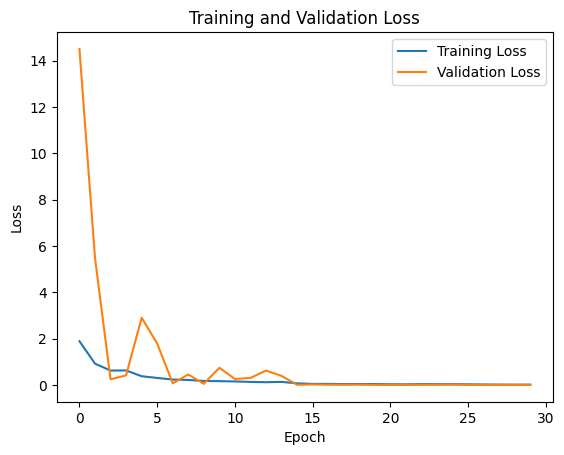

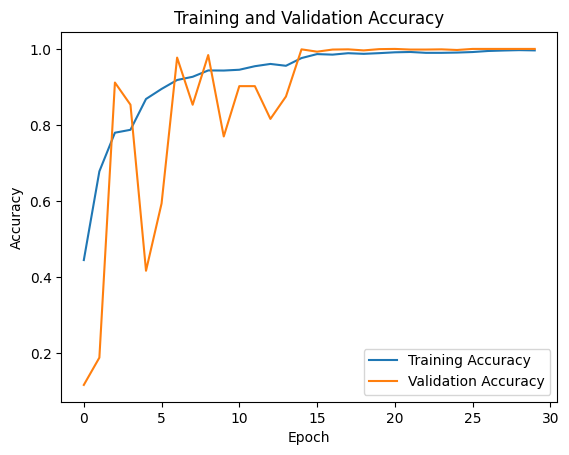

In [18]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



Görüldüğü üzere aykırı ve anormal bir sonuç ile karşılaşmadık olması gereken bir grafik gözlemledik bu da aşırı öğrenmenin olmadığını gösterir